In [4]:
%gui qt
import torch
import torchio as tio
from torch.utils.data import DataLoader
import scipy.io
from scipy.ndimage import maximum_filter
import pandas as pb
import numpy as np
import napari

# Generation of training data

We have volumes of micro-ct data that we are trying to label. However, the labels we currently have are 3d point locations, which isn't a format that our deep learning model can link spatially to our ct data. 

We want to convert these 3d point locations into a new "prediction volume". This is what we want our deep learning model to end up producing. It is also a format that our deep learning model can read, link spatially to our data and produce.

## Let's first set up some helper functions to generate annotated prediction volumes for our analysis.

In [6]:
def _load_point_data(dir):
    print('loading point data from .mat files...')
    # load classifications
    mat = scipy.io.loadmat(dir)
    classification = pb.DataFrame(
        mat['save_dat'][0]['data'][0][0][0][0]).iloc[:, 5]
    points = pb.DataFrame(
        mat['save_dat'][0]['data'][0][0][0][0]).iloc[:, [2, 1, 0]]
    points.columns = ['x', 'y', 'z']
    # convert back to numpy array and round to nearest voxel
    points = np.array(points)
    points = np.round(points).astype(int)
    # get corneas and rhabdom locations with x, y and z data
    cornea_indx = (classification == 0) | (classification == 2)
    rhabdom_indx = (classification == 1) | (classification == 3)
    cornea_locations = points[cornea_indx, :]
    rhabdom_locations = points[rhabdom_indx, :]

    return cornea_locations, rhabdom_locations

def _point_to_segmentation_vol(image, cornea_locations, rhabdom_locations):
    print('converting point data to segmentation volume...')
    # create empty matrix the size of original data
    empty = image.copy()
    empty[:, :, :] = 0
    
    corneas = empty.copy()
    rhabdoms = empty.copy()
    
    corneas[
        0,
        cornea_locations[:, 2],
        cornea_locations[:, 1],
        cornea_locations[:, 0]
    ] = 1
    rhabdoms[
        0,
        rhabdom_locations[:, 2],
        rhabdom_locations[:, 1],
        rhabdom_locations[:, 0]
    ] = 1
    
    # now use a maximum filter to make points a slightly larger area
    # note, that maximum filter makes predictions a cube without rounded edges
    corneas = maximum_filter(corneas, size=15)
    rhabdoms = maximum_filter(rhabdoms, size=15)

    # now merge both into a single prediction volume
    # 0 = nothing
    # 1 = cornea
    # 2 = rhabdom
    prediction = empty
    prediction[corneas > 0] = 1
    prediction[rhabdoms > 0] = 2
    
    return prediction

def create_annotated_volumes(dir, image):
    cornea_locations, rhabdom_locations = _load_point_data(dir)
    annotated_vol = _point_to_segmentation_vol(
        image,
        cornea_locations,
        rhabdom_locations
    )
    print('done.')
    return annotated_vol
    

## Let's load our mct volumes and point data to make segmentation labels for training

In [9]:
id = 
img_dir = '//media/jake/1tb_ssd/mctv_analysis/head_scans/P_crassipes_FEG191022_077A_highpriority'
matlab_ann_dir = '//media/jake/1tb_ssd/mctv_analysis/mctv_resfiles/hyperiids/P_crassipes_FEG191022_077A/P_crassipes_FEG191022_077A.mat'
labels_dir = '//media/jake/1tb_ssd/mctv_analysis/labels/'

transform = tio.ToCanonical()
img = tio.ScalarImage(
    img_dir
)
ann = tio.LabelMap(
    tensor=create_annotated_volumes(
        matlab_ann_dir,
        img.data.numpy()
    )
)

loading point data from .mat files...
converting point data to segmentation volume...
done.


In [10]:
with napari.gui_qt():
  viewer = napari.Viewer()
  viewer.dims.ndisplay = 3 # toggle 3 dimensional view
  viewer.add_image(img.data.numpy())
  viewer.add_image(ann.data.numpy())

PythonQtError: No Qt bindings could be found.

napari requires either PyQt5 or PySide2 to be installed in the environment.
To install the default backend (currently PyQt5), run "pip install napari[all]" 
You may also use "pip install napari[pyside2]"for Pyside2, or "pip install napari[pyqt5]" for PyQt5

Let's double check that the affine matrices are the same

In [11]:
img.affine

array([[-0.00287747,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00287747,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00287747,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [12]:
ann.affine

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Now let's do a plot to make sure everything looks ok

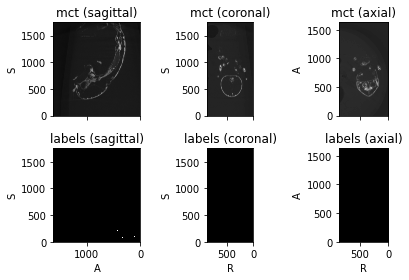

In [13]:
subject = tio.Subject(
    mct=img,
    labels=ann,
    id=id
)
subject.plot()

Now that we've generated our labels, let's save them to disk so they can be loaded by our model for training.

In [ ]:
ann.save('_label.nii.gz')

Now we can load this data quickly during training and testing. This can be done with the approach below.

In [ ]:
img = tio.ScalarImage(
    
)
ann = tio.LabelMap(
    'data/'+ id + '/' + id + '_label.nii.gz',
    affine=img.affine
)
subject = tio.Subject(
    mct=img,
    labels=ann,
    id=id
)
subject.plot()